# 1. Introdução
------
Este notebook tem por objetivo ensinar como utilizar a biblioteca do GPA, além de apresentar alguns testes de matrizes fundamentais. 


Rode a célula a seguir, caso esteja utilizando o colab

In [ ]:
!pip install git+https://github.com/rsautter/GPA@V4

  Cloning https://github.com/rsautter/GPA (to revision V4) to /tmp/pip-req-build-0zb7jrj6
  Running command git clone -q https://github.com/rsautter/GPA /tmp/pip-req-build-0zb7jrj6
  Running command git checkout -b V4 --track origin/V4
  Switched to a new branch 'V4'
  Branch 'V4' set up to track remote branch 'V4' from 'origin'.
  Created wheel for GPA: filename=GPA-4.0-py3-none-any.whl size=6848 sha256=b3caff06673850f893092fab6f08d8f28c22d4ac9a983c796db82e22e6a7d8cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbvhsprv/wheels/01/38/8c/486d2777ffb87ef75c1e4c2e337125cd566f094df5fe460043
Successfully built GPA


A célula a seguir invoca as bibliotecas de manipulação de vetores, plotagem e o próprio GPA 

In [ ]:
from GPA2D import GPA2D
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
import matplotlib.patches as mpatches

# 2. Utilizando o GPA
------
O GPA foi implementado como um objeto que analis como um objeto que analisa vetores do tipo numpy. Parte do algoritmo consiste na detecção de simetrias no padrão, nesta implementação foi adotado a simetria concêntrica/rotacional. Neste tipo de simetria vetores que estão equidistantes ao centro do padrão são comparados entre si. Caso exista ao menos um vetor cuja soma seja o vetor nulo, então este vetor é dito simétrico. 

A figura a seguir mostra um exemplo do processo de detecção de simetria concêntrica, o círculo mostra uma determinada distância avaliada. Neste padrão todos os vetores são simétricos, pois para cada vetor existe um outro vetor a 180º em relação ao centro, com módulo igual e fase oposta.

<img src='https://raw.githubusercontent.com/rsautter/GPA/master/Figures/Remotion.png'>

Há um parâmetro de tolerância que é fornecido ao método construtor do GPA, para avaliar se dois pares de vetores são simétricos. No exemplo a seguir, a tolerância é 0.01, porém qualquer medida entre zero e um pode ser considerada. Este parâmetro determina a partir do maior vetor no padrão a ser analisado qual a tolerância do algoritmo de detecção de simetria.

In [ ]:
ga = GPA2D(0.01)

In [ ]:
mat = [[0,0,0],
       [0,1,0],
       [0,0,0]]
mat = np.array(mat).astype(np.float)

O método \_\_*call*\_\_ realiza a medida dos momentos do campo gradiente. Há três parâmetros:

 - mat - A matriz de entrada do tipo float
 - moment - Lista de momentos do campo gradiente a serem medidos ('G1','G2','G3' ou 'G4')
 - symmetrycalGrad - Determina se a medida será realizada sobre o campo simétrico, codificado como:
    - 'S'  - campo simétricos
    - 'A'  - campo assimétrico
    - 'F'  - campo gradiente completo (G4 não pode ser medido neste modo)
    - 'K'  - campo gradiente completo, exceto por vetores nulos


Por padrão os parâmetros são:

    moment = ['G2']
    symmetrycalGrad = 'A'

Neste exemplo a matriz é completamente simétrica.

In [ ]:
moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente simétrico: {'G1': 0.25, 'G1N': 0.449, 'G2': 1.0, 'G3': 0.0, 'G4': (3.1415926535897936+3.141592653589793j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 0.25, 'G1N': 0.449, 'G2': 0.444, 'G3': 0.0, 'G4': (3.1415926535897936+3.141592653589793j)}
Momentos do campo gradiente completo: {'G1': 0.778, 'G1N': 0.57, 'G2': 1.0, 'G3': 0.816}


## 2.1. Momentos do Campo Gradiente

###  Primeiro Momento  do Campo Gradiente ($G_1$)
O primeiro momento do campo gradiente é calculado a partir da triangulação de Delaunay. A medida é a razão entre o número de conexões ($N_C$) em relação ao número de vetores ($N_V$). Por meio de testes [(ROSA et. al., 1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), foi constatado que a medida está limitada ao intervalo \[0, 2\[. O motivo para tal limite ainda é desconhecido.   

$$G_1 = {N_C-N_V \over N_V} = {N_C \over N_V}-1$$

Uma medida alternativa para o primeiro momento, que é normalizada, é dado por:

$$G^N_1 = e^{- {N_V \over N_C}}$$


### Segundo Momento do Campo Gradiente Assimétrico ($G_2$)
O segundo momento do campo gradiente é uma medida que relacionada a proporção de vetores assimétricos(${V_A / V}$) e a variabilidade dos módulos ($ {|\sum v^A| / \sum|v^A|}$) . Esta medida era ajustada ao intervalo $[0,2]$, conforme descrito por [Barchi, et.al.,(2017)](https://arxiv.org/abs/1705.06818), com o intuito de comparar aos demais momentos do campo gradiente. Atualmente essa medida é normalizada ao intervalo $[0,1]$

$$ G_2 = {V_A \over V} \left( 1 - {|\sum v^A|\over 2\sum|v^A|}\right)$$

### Segundo Momento do Campo Gradiente Simétrico ($G^S_2$)
A medida utilizada no segundo momento do campo gradiente assimétrico não é ser util para muito casos de campos simétricos. Por exemplo, O somatório de vetores simétricos é sempre zero ($|\sum v^S| = 0$), tornando a medida constante para o caso de um padrão simétrico bilateralmente. Como alternativa, utiliza-se equação a seguir, onde $||v^S_{i,j}||$ é o módulo de um determinado vetor simétrico, normalizado pelo maior módulo de vetor simétrico.

$$G^S_2 = - \sum ||v^S||ln\left(||v^S||\right)$$
 
###  Terceiro Momento do Campo Gradiente ($G_3$)

Toda medida realizada exclusivamente sobre o conjunto de fases de um campo gradiente pertence ao terceiro momento do campo gradiente, segundo formalismo da análise de padrões do campo gradiente. Uma medida possível é a variabilidade das fases, onde $\sigma$ é o desvio padrão. Na equação a seguir $u$ e $v$ são vetores unitários, cuja direção indica, respectivamente, a direção do gradiente em um dado ponto e a direção desse vetor em relação ao centro de simetria.

$$G_3 = \sigma (u.v)$$

Em um caso 2D, o conjunto de fases $\theta_i$ posicionada ao respectivo ângulo $\phi_i$ em relação ao centro, tem como terceiro momento:

$$G_3 = \sigma( cos(\theta_i)cos(\phi_i)+sin(\theta_i)sin(\phi_i) )$$

O produto nessa medida, pode ser visto como uma mudança para o referencial do centro de simetria, uma vez que por definição o produto interno é:

$$u.v = |u||v|cos(\gamma) = cos(\gamma)$$

A figura a seguir mostra a relação entre os vetores $u$ e $v$ e a resposta do produto interno. 
<center>
<img src='https://raw.githubusercontent.com/rsautter/GPA/master/Figures/G3Exp.png'>
</center>

###  Quarto Momento do Campo Gradiente ($G_4$)

O quarto momento do campo gradiente é definido por medidas da representação  complexa, onde $z_{x,y} = a+ bi$.
 [Neto, et. al.(2000)](https://www.worldscientific.com/doi/abs/10.1142/S0129183101002504?casa_token=WD_wImLA5_AAAAAA:L0DMr350Si3FPygbvYx4KZAPLrw6l1oiBJ3TjyvqBQlNSeGM1K-jjsv_RHXXd5IHuLZeDZvqWBeIzeQ) propôem uma medida de entropia da forma complexa do campo gradiente, conforme a equação abaixo, onde $z=\sum z_{i,j}$

 $$ G_4 = - \sum {z_{x,y} \over z} ln \left( {z_{x,y} \over z}  \right)$$

Para o caso tridimensional, o número complexo é representado por [quaternions](https://en.wikipedia.org/wiki/Quaternion), cuja implementação provém da biblioteca [Sympy](https://docs.sympy.org/latest/modules/algebras.html). Por definição esse sistema numérico possui um número escalar e três números complexos, tal que: 

$$z_{x,y,z} = a +bi++cj+dk = a + v $$

O logaritmo natural nesse sistema é calculado como:

$$ ln(z_{x,y,z})  = ln |z| + {v \over |v|} arccos \left( {a \over |q|} \right) $$

Afim de evitar um erro de aproximação , considera-se apenas a parte real do quaternion resultante quando a parte complexa do quaternion original é nula ($|v| = 0.0$). O principal motivo é que neste caso, o vetor aponta em apenas no eixo dos números reais, sendo assim possível aproximar a função logaritmica do quaternion, como a função logaritmica dos números reais.

## 2.2. Plot


O plot a seguir mostra a matriz de amplitudes, o campo gradiente e a classificação dos vetores quanto a simetria. Infelizmente, para o caso de um padrão somente com vetores indeterminados, como uma matriz constante, a função [quiver](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) não funciona propriamente.

Outro aspecto importante é que por padrão matrizes numpy possuem origem no canto superior esquerdo, enquanto o padrão da matplotlib a origem é o canto inferior esquerdo.

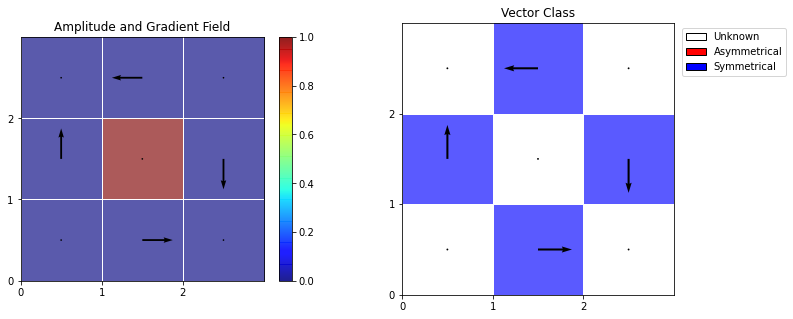

In [ ]:
def plotGPAVecClass(mat,ga):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    im = plt.imshow(mat,origin='lower',alpha=0.65,cmap = 'jet',extent=[0,len(mat),0,len(mat)])
    plt.colorbar(im,shrink=0.9)
    meshgrid = np.meshgrid(np.arange(0,len(mat))+.5,np.arange(0,len(mat))+.5)
    plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.gca().set_xticks(np.arange(0, len(mat)), minor=False)
    plt.gca().set_yticks(np.arange(0,  len(mat)), minor=False)
    plt.gca().grid(which='major', color='w', linestyle='-', linewidth=1)
    plt.title("Amplitude and Gradient Field")
    plt.subplot(1,2,2)
    classificationMap = np.array(ga.unknownP) + 3*np.array(ga.asymmetricalP) + 5*np.array(ga.symmetricalP) 
    
    cmap = colors.ListedColormap(['white','red','blue'])
    norm = colors.BoundaryNorm([0,2,5,6], cmap.N)
    plt.imshow(classificationMap,origin='lower',cmap=cmap,extent=[0,len(mat),0,len(mat)],alpha=0.65,norm=norm)
    plt.quiver(meshgrid[0],meshgrid[1],ga.gradient_dx,ga.gradient_dy)
    plt.gca().set_xticks(np.arange(0, len(mat)), minor=False)
    plt.gca().set_yticks(np.arange(0,  len(mat)), minor=False)
    plt.gca().grid(which='major', color='w', linestyle='-', linewidth=1)
    legendColors = [mpatches.Patch(facecolor='white', label='Unknown', edgecolor='k'),
                    mpatches.Patch(facecolor='red', label='Asymmetrical', edgecolor='k'),
                    mpatches.Patch(facecolor='blue', label='Symmetrical', edgecolor='k')]
    plt.legend(handles=legendColors, bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Vector Class")
    plt.show()
    
plotGPAVecClass(mat,ga)

# 3. Matrizes Fundamentais
------

O conceito original de matriz fundamental foi estabelecido por [Rosa et. al., (1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), como a menor matriz que possui um elemento central, ou seja uma matriz fundamental 2D de tamanho 3x3. Este tipo de padrão é importante para entender os algoritmos propostos e validar a implementação.


Neste sentido, são apresentados quatro categorias de matrizes fundamentais:

    - simétricas
    - assimétricas
    - indeterminado
    - misto

## 3.1. Simétrica

In [ ]:
mat = [[0,2,0],
       [2,1,2],
       [0,2,0]]
mat = np.array(mat).astype(np.float)
  
moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente simétrico: {'G1': 0.5, 'G1N': 0.513, 'G2': 0.943, 'G3': 1.0, 'G4': (5.553603672697958+1.1107207345395915j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 0.5, 'G1N': 0.513, 'G2': 1.0, 'G3': 1.0, 'G4': (5.553603672697958+1.1107207345395915j)}
Momentos do campo gradiente completo: {'G1': 0.333, 'G1N': 0.472, 'G2': 1.0, 'G3': 0.994}


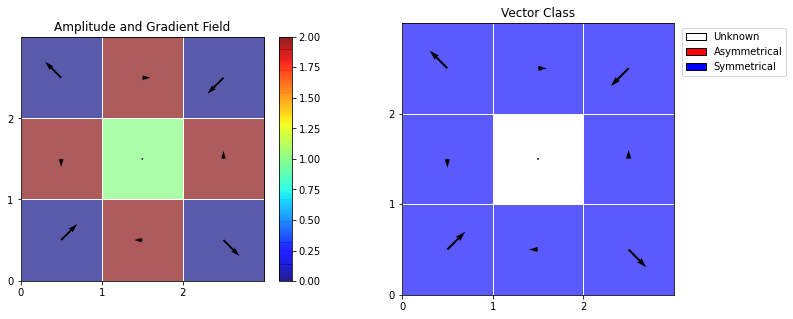

In [ ]:
plotGPAVecClass(mat,ga)

## 3.2. Assimétrico

In [ ]:
mat = [[3,6,4],
       [6,0,6],
       [4,7,4]]

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 1.0, 'G1N': 0.607, 'G2': 0.958, 'G3': 0.988, 'G4': (5.415894209876487+2.5850055036987136j)}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 1.0, 'G1N': 0.607, 'G2': 0.958, 'G3': 0.988, 'G4': (5.415894209876487+2.5850055036987136j)}
Momentos do campo gradiente completo: {'G1': 1.0, 'G1N': 0.607, 'G2': 0.958, 'G3': 0.988}


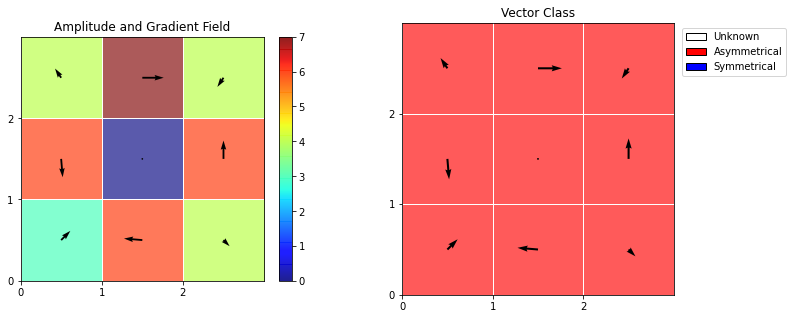

In [ ]:
plotGPAVecClass(mat,ga)

## 3.3. Misto

In [ ]:
mat = [[3,6,5],
       [6,0,6],
       [4,6,3]]

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.5, 'G1N': 0.513, 'G2': 0.722, 'G3': 0.939, 'G4': (4.57873645630815+4.330451269579785j)}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 1.0, 'G3': 0.0, 'G4': (1.5494239523283362-1.549423952328336j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 0.875, 'G1N': 0.587, 'G2': 0.971, 'G3': 0.996, 'G4': (6.128160408636486+2.78102731725145j)}
Momentos do campo gradiente completo: {'G1': 1.0, 'G1N': 0.607, 'G2': 0.971, 'G3': 0.99}


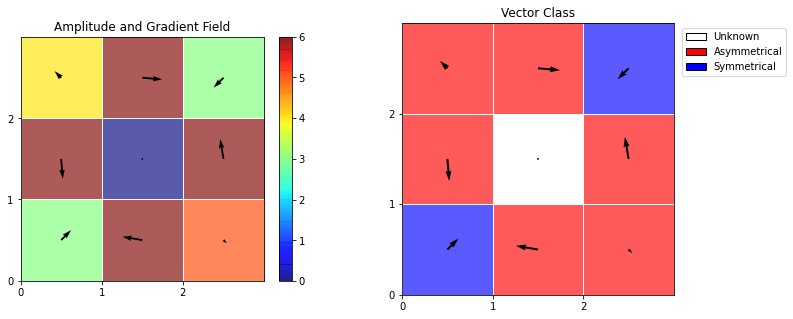

In [ ]:
plotGPAVecClass(mat,ga)

In [ ]:
mat = [[0,0,0],
       [2,0,2],
       [0,2,0]]
       
moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.833, 'G1N': 0.58, 'G2': 0.661, 'G3': 0.882, 'G4': (4.43495261502089-0j)}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 1.0, 'G3': 1.0, 'G4': (2.221441469079183-0j)}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 0.625, 'G1N': 0.54, 'G2': 0.91, 'G3': 0.919, 'G4': (6.656394084100073-0j)}
Momentos do campo gradiente completo: {'G1': 0.444, 'G1N': 0.5, 'G2': 0.91, 'G3': 0.942}


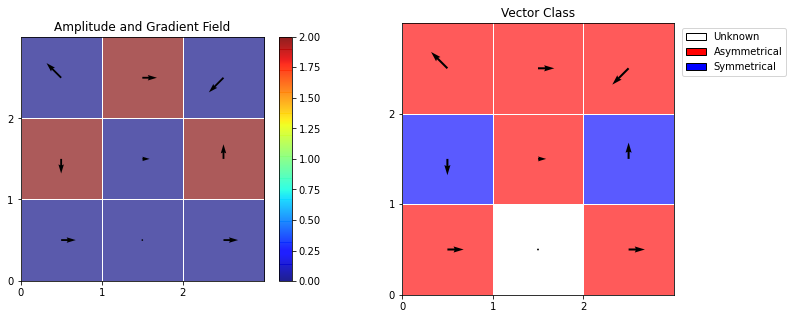

In [ ]:
plotGPAVecClass(mat,ga)

## 3.4. Indeterminado

In [ ]:
mat = [[0,0,0],
       [0,0,0],
       [0,0,0]]

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)


Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0j}
Momentos do campo gradiente completo: {'G1': 0.778, 'G1N': 0.57, 'G2': 1.0, 'G3': 0.737}


# Referências

[1] Rosa, Reinaldo R., A. S. Sharma, and J. A. Valdivia. "Characterization of asymmetric fragmentation patterns in spatially extended systems." International Journal of Modern Physics C 10.01 (1999): 147-163.

[2] Barchi, P. H., et al. "Improving galaxy morphology with machine learning." arXiv preprint arXiv:1705.06818 (2017).

[3] Neto, C. Rodrigues, R. R. Rosa, and F. M. Ramos. "Pattern characterization: A case study in osmosedimentation." International Journal of Modern Physics C 12.08 (2001): 1261-1269.

### Extra - Plot

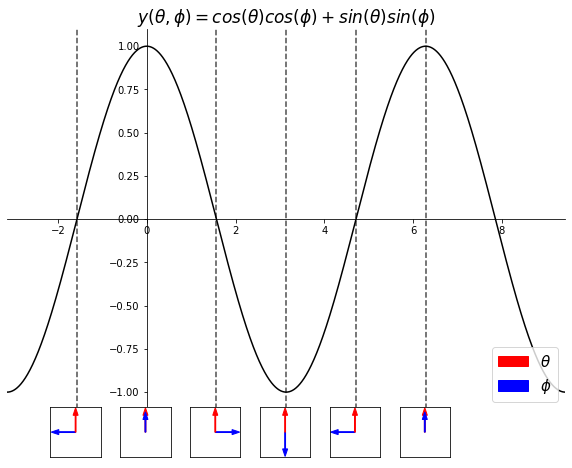

In [ ]:

fig = plt.figure(figsize=(10,7))

ax = plt.subplot(1,1,1)
x = np.linspace(-np.pi,3*np.pi,2000)
y = np.cos(x)
plt.plot(x,y,color='k')
plt.xlim(-np.pi,3*np.pi)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

plt.axvline(-np.pi/2,c='k',ls='--',alpha=0.7)
plt.axvline(np.pi,c='k',ls='--',alpha=0.7)
plt.axvline(np.pi/2,c='k',ls='--',alpha=0.7)
plt.axvline(2*np.pi,c='k',ls='--',alpha=0.7)
plt.axvline(3*np.pi/2,c='k',ls='--',alpha=0.7)
plt.title(r'$y(\theta,\phi) = cos(\theta)cos(\phi)+sin(\theta)sin(\phi)$',fontsize=17)


theta = mpatches.Patch(color='red', label=r'$\theta$')
phi = mpatches.Patch(color='blue', label=r'$\phi$')
plt.legend(handles=[theta,phi],loc='lower right',fontsize=15)


fig.add_axes([0.185,0.03,0.07,0.1])
plt.arrow(0,0,-1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

delta = 0.097
fig.add_axes([0.185+delta,0.03,0.07,0.1])
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.arrow(0,0,0,0.75,width=0.05,head_width=0.3,color='blue')

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+2*delta,0.03,0.07,0.1])
plt.arrow(0,0,1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+3*delta,0.03,0.07,0.1])
plt.arrow(0,0,0,-1,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+4*delta,0.03,0.07,0.1])
plt.arrow(0,0,-1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+5*delta,0.03,0.07,0.1])
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.arrow(0,0,0,0.75,width=0.05,head_width=0.3,color='blue')

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

mpatches
#ax.grid()

plt.show()

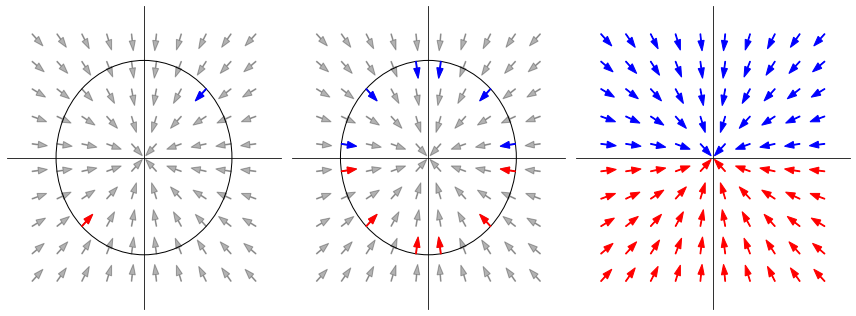

In [ ]:
n = 10
center = n//2-0.5
inverseDistanceW = 4
alpha = 0.3

plt.figure(figsize=(12,4.5))

plt.subplot(1,3,1)

for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='black',alpha=alpha)

x,y = 2,2
d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
dx,dy = center-x,center-y
dx,dy = dx/d,dy/d
plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)

x,y = 7,7
d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
dx,dy = center-x,center-y
dx,dy = dx/d,dy/d
plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

circle = plt.Circle((center, center), np.sqrt((x-center)**2+ (y-center)**2), color='k',fill=False)
ax = plt.gca()
ax.add_patch(circle)

plt.xlim(-1,10)
plt.ylim(-1,10)

ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')

plt.xticks([])
plt.yticks([])

'''
Mesma distancia
'''
dtarget = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
plt.subplot(1,3,2)
for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='black',alpha=alpha)
    if np.abs(d-dtarget) <0.3:
      if(y<center):
        plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)
      else:
        plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

x,y = 7,7
circle = plt.Circle((center, center), np.sqrt((x-center)**2+ (y-center)**2), color='k',fill=False)
ax = plt.gca()
ax.add_patch(circle)

plt.xlim(-1,10)
plt.ylim(-1,10)

ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])

'''
Todos removidos
'''
dtarget = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
plt.subplot(1,3,3)
for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    if y<center:
      plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)
    else:
      plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

plt.xlim(-1,10)
plt.ylim(-1,10)
ax = plt.gca()
ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()